## Segmentation

While in the classification task we assign a label to the image, in the segmentation task a label is assigned to each of the pixels in the image. Thus, the neural network will output another image (with the same resolution as the input image) in which we have a class assigned to each pixel. If our network also allows us to recognize different objects of the same category, we speak of semantic segmentation.

## UNet Implementation

The dataset

We can download a set of MRI images with their corresponding segmentation masks using the following link.texto en cursiva

In [ ]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs (1).zip'

In [ ]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca

In [ ]:
import os 
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

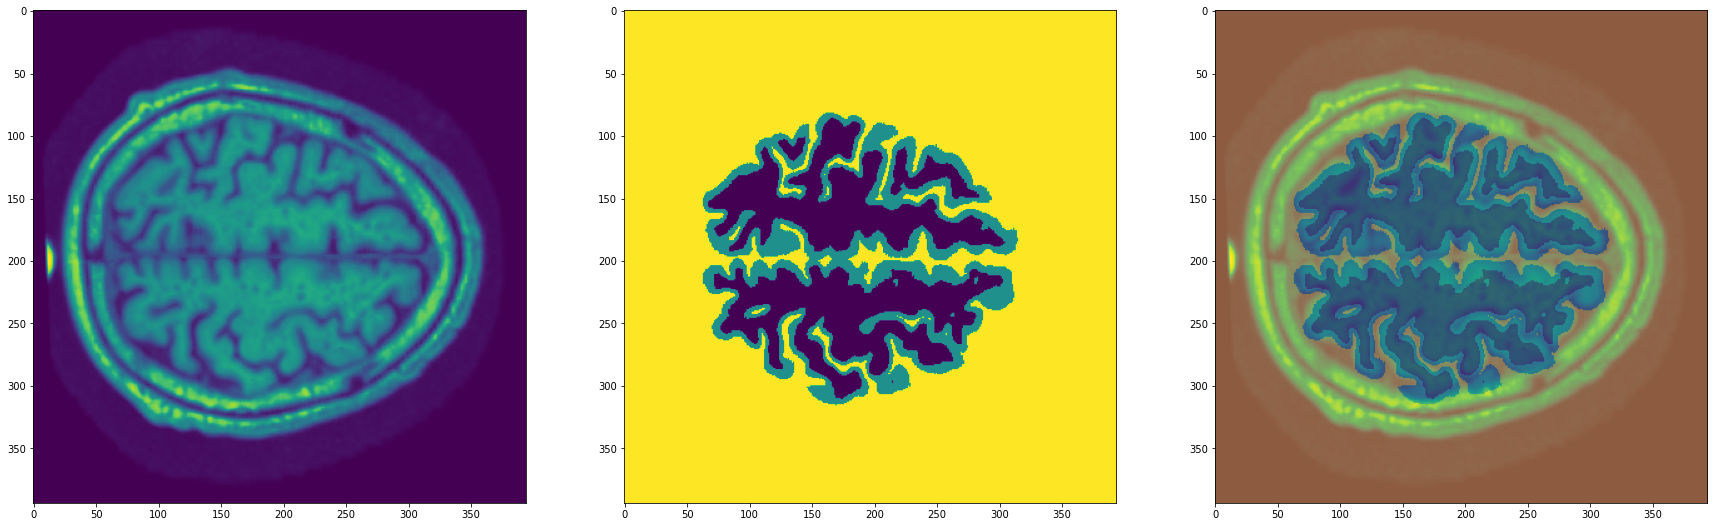

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Images are 394 x 394 pixels, stored as NumPy arrays (can be loaded with the np.load function). They are already normalized and in float32 format.

In [ ]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.1069179, 0.00025629325)

The masks are also NumPy arrays, in this case the type is unit8, and the resolution is the same as the original image. In each pixel we can find three possible values: 0, 1 or 2. This value indicates the class (0 corresponds to white matter, 1 to gray matter, 2 to background).

In [ ]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

Mask in one-hot encoding format, in which we will extend each pixel in a list of length equal to the number of classes with values of 0 in all positions except the one that corresponds to the class, where we will put a 1.

In [ ]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

## UNet Model

In [ ]:
import torch
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # receives the output of the previous layer and the output of the stage
    # corresponding encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # we concatenate the tensors
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # list of layers in encoder-decoder with number of filters
        c = [16, 32, 64, 128]

        # first conv layer that receives the image
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # encoder layers
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # encoder layers
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # last layer that gives us the mask
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((10,1,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

## One Sample Fit

To optimize the network we use the loss function BCEWithLogitsLoss, which will apply the sigmoid activation function to the network outputs (so that they are between 0 and 1) and then compute the binary cross entropy function.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [ ]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.67771
Epoch 2/20 loss 0.65673
Epoch 3/20 loss 0.63978
Epoch 4/20 loss 0.62502
Epoch 5/20 loss 0.61244
Epoch 6/20 loss 0.60108
Epoch 7/20 loss 0.59056
Epoch 8/20 loss 0.58058
Epoch 9/20 loss 0.57086
Epoch 10/20 loss 0.56144
Epoch 11/20 loss 0.55234
Epoch 12/20 loss 0.54351
Epoch 13/20 loss 0.53490
Epoch 14/20 loss 0.52646
Epoch 15/20 loss 0.51817
Epoch 16/20 loss 0.51001
Epoch 17/20 loss 0.50199
Epoch 18/20 loss 0.49411
Epoch 19/20 loss 0.48637
Epoch 20/20 loss 0.47871


We use the IoU metric to evaluate how close the predicted masks are to the real ones

In [ ]:
def iou(outputs, labels):
    # apply sigmoid and convert to binary
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # we jump the background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.47111 iou 0.49109
Epoch 2/100 loss 0.44705 iou 0.54382
Epoch 3/100 loss 0.42284 iou 0.57873
Epoch 4/100 loss 0.40470 iou 0.58143
Epoch 5/100 loss 0.38637 iou 0.57310
Epoch 6/100 loss 0.36947 iou 0.58299
Epoch 7/100 loss 0.35237 iou 0.60466
Epoch 8/100 loss 0.33828 iou 0.61602
Epoch 9/100 loss 0.32495 iou 0.61580
Epoch 10/100 loss 0.31119 iou 0.61479
Epoch 11/100 loss 0.29895 iou 0.60864
Epoch 12/100 loss 0.28733 iou 0.60831
Epoch 13/100 loss 0.27618 iou 0.61080
Epoch 14/100 loss 0.26579 iou 0.61294
Epoch 15/100 loss 0.25522 iou 0.62478
Epoch 16/100 loss 0.24524 iou 0.63247
Epoch 17/100 loss 0.23504 iou 0.64042
Epoch 18/100 loss 0.22792 iou 0.63000
Epoch 19/100 loss 0.22041 iou 0.63327
Epoch 20/100 loss 0.21314 iou 0.64481
Epoch 21/100 loss 0.20538 iou 0.65458
Epoch 22/100 loss 0.19797 iou 0.65407
Epoch 23/100 loss 0.19036 iou 0.65976
Epoch 24/100 loss 0.18378 iou 0.66435
Epoch 25/100 loss 0.17727 iou 0.67734
Epoch 26/100 loss 0.17039 iou 0.69166
Epoch 27/100 loss 0.1

## Evaluation

Now we can generate predictions to get segmentation masks

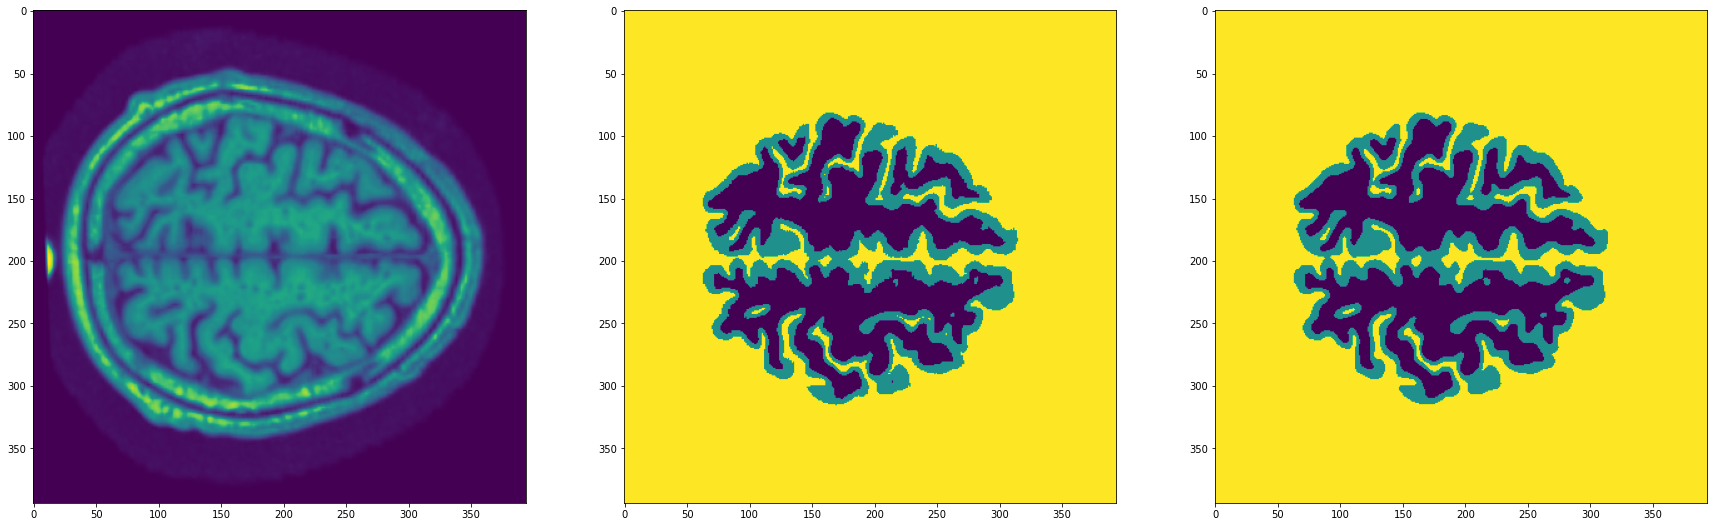

In [ ]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Training with the entire dataset

Once we have validated that our network is capable of fitting an image, we can train the network with the entire dataset.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [ ]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.63855 test_iou 0.04708: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]



Epoch 1/30 loss 0.56127 iou 0.25747 test_loss 0.63855 test_iou 0.04708


test_loss 0.42845 test_iou 0.36557: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it]



Epoch 2/30 loss 0.41079 iou 0.48840 test_loss 0.42845 test_iou 0.36557


test_loss 0.26003 test_iou 0.49068: 100%|██████████| 4/4 [00:32<00:00,  8.16s/it]



Epoch 3/30 loss 0.31288 iou 0.52259 test_loss 0.26003 test_iou 0.49068


test_loss 0.21699 test_iou 0.46207: 100%|██████████| 4/4 [00:33<00:00,  8.44s/it]



Epoch 4/30 loss 0.24924 iou 0.47670 test_loss 0.21699 test_iou 0.46207


test_loss 0.18182 test_iou 0.48689: 100%|██████████| 4/4 [00:33<00:00,  8.44s/it]



Epoch 5/30 loss 0.20687 iou 0.50030 test_loss 0.18182 test_iou 0.48689


test_loss 0.16887 test_iou 0.56601: 100%|██████████| 4/4 [00:34<00:00,  8.53s/it]



Epoch 6/30 loss 0.17734 iou 0.54543 test_loss 0.16887 test_iou 0.56601


test_loss 0.14829 test_iou 0.58848: 100%|██████████| 4/4 [00:33<00:00,  8.27s/it]



Epoch 7/30 loss 0.15488 iou 0.59993 test_loss 0.14829 test_iou 0.58848


test_loss 0.13940 test_iou 0.59913: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]



Epoch 8/30 loss 0.13830 iou 0.63800 test_loss 0.13940 test_iou 0.59913


test_loss 0.12001 test_iou 0.67395: 100%|██████████| 4/4 [00:33<00:00,  8.40s/it]



Epoch 9/30 loss 0.12447 iou 0.66431 test_loss 0.12001 test_iou 0.67395


test_loss 0.10950 test_iou 0.68858: 100%|██████████| 4/4 [00:33<00:00,  8.32s/it]



Epoch 10/30 loss 0.11373 iou 0.68675 test_loss 0.10950 test_iou 0.68858


test_loss 0.09929 test_iou 0.71258: 100%|██████████| 4/4 [00:34<00:00,  8.57s/it]



Epoch 11/30 loss 0.10455 iou 0.70428 test_loss 0.09929 test_iou 0.71258


test_loss 0.09684 test_iou 0.70833: 100%|██████████| 4/4 [00:34<00:00,  8.51s/it]



Epoch 12/30 loss 0.09729 iou 0.71609 test_loss 0.09684 test_iou 0.70833


test_loss 0.09058 test_iou 0.72662: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]



Epoch 13/30 loss 0.09253 iou 0.72305 test_loss 0.09058 test_iou 0.72662


test_loss 0.08633 test_iou 0.72275: 100%|██████████| 4/4 [00:35<00:00,  8.80s/it]



Epoch 14/30 loss 0.08682 iou 0.73360 test_loss 0.08633 test_iou 0.72275


test_loss 0.08178 test_iou 0.73044: 100%|██████████| 4/4 [00:33<00:00,  8.37s/it]



Epoch 15/30 loss 0.08258 iou 0.74167 test_loss 0.08178 test_iou 0.73044


test_loss 0.07924 test_iou 0.73467: 100%|██████████| 4/4 [00:34<00:00,  8.60s/it]



Epoch 16/30 loss 0.07923 iou 0.74583 test_loss 0.07924 test_iou 0.73467


test_loss 0.07784 test_iou 0.73291: 100%|██████████| 4/4 [00:35<00:00,  8.86s/it]



Epoch 17/30 loss 0.07620 iou 0.74938 test_loss 0.07784 test_iou 0.73291


test_loss 0.07485 test_iou 0.73901: 100%|██████████| 4/4 [00:36<00:00,  9.01s/it]



Epoch 18/30 loss 0.07452 iou 0.75011 test_loss 0.07485 test_iou 0.73901


test_loss 0.07471 test_iou 0.73532: 100%|██████████| 4/4 [00:34<00:00,  8.71s/it]



Epoch 19/30 loss 0.07138 iou 0.75729 test_loss 0.07471 test_iou 0.73532


test_loss 0.07177 test_iou 0.74106: 100%|██████████| 4/4 [00:34<00:00,  8.60s/it]



Epoch 20/30 loss 0.07115 iou 0.75272 test_loss 0.07177 test_iou 0.74106


test_loss 0.06987 test_iou 0.74981: 100%|██████████| 4/4 [00:33<00:00,  8.40s/it]



Epoch 21/30 loss 0.06698 iou 0.76658 test_loss 0.06987 test_iou 0.74981


test_loss 0.07130 test_iou 0.73602: 100%|██████████| 4/4 [00:39<00:00,  9.79s/it]



Epoch 22/30 loss 0.06573 iou 0.76577 test_loss 0.07130 test_iou 0.73602


test_loss 0.06925 test_iou 0.74379: 100%|██████████| 4/4 [00:34<00:00,  8.56s/it]



Epoch 23/30 loss 0.06432 iou 0.76957 test_loss 0.06925 test_iou 0.74379


test_loss 0.07223 test_iou 0.72233: 100%|██████████| 4/4 [00:33<00:00,  8.31s/it]



Epoch 24/30 loss 0.06286 iou 0.77218 test_loss 0.07223 test_iou 0.72233


test_loss 0.06621 test_iou 0.75024: 100%|██████████| 4/4 [00:33<00:00,  8.31s/it]



Epoch 25/30 loss 0.06142 iou 0.77370 test_loss 0.06621 test_iou 0.75024


test_loss 0.06367 test_iou 0.75586: 100%|██████████| 4/4 [00:35<00:00,  9.00s/it]



Epoch 26/30 loss 0.05910 iou 0.78156 test_loss 0.06367 test_iou 0.75586


test_loss 0.06762 test_iou 0.72941: 100%|██████████| 4/4 [00:34<00:00,  8.66s/it]



Epoch 27/30 loss 0.05782 iou 0.78576 test_loss 0.06762 test_iou 0.72941


test_loss 0.07576 test_iou 0.70235: 100%|██████████| 4/4 [00:33<00:00,  8.38s/it]



Epoch 28/30 loss 0.05757 iou 0.78291 test_loss 0.07576 test_iou 0.70235


test_loss 0.06619 test_iou 0.74085: 100%|██████████| 4/4 [00:34<00:00,  8.57s/it]



Epoch 29/30 loss 0.05577 iou 0.78912 test_loss 0.06619 test_iou 0.74085


test_loss 0.06902 test_iou 0.73376: 100%|██████████| 4/4 [00:34<00:00,  8.68s/it]


Epoch 30/30 loss 0.05456 iou 0.79274 test_loss 0.06902 test_iou 0.73376


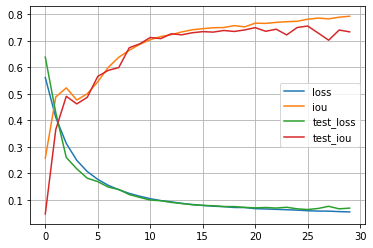

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

We use an already trained network, for this we will use ResNet as a backbone in the encoder as follows, looking for an improvement in results

In [ ]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet()
output = model(torch.randn((10,1,394,394)))
output.shape

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([10, 3, 394, 394])

In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In this case we observe how the network converges faster, however we do not obtain a great improvement in performance since our dataset is very small and the nature of the images is very different from those used to train ResNet.

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()